# Содержание

1 [Подготовка](#1) Собраться, чтобы никто не мешал :)

- [Просмотр полученных данных](#1.1)

2 [Предварительная обработка](#2)

- [Объединение таблиц](#2.1)
- [Создание целевого признака](#2.2)
- [Замена типов данных](#2.3)
- [Создание дополнительных признаков](#2.4)
- [Обработка ошибок в данных](#2.5)

3 [Анализ данных](#3)

- [Общиая анализ](#3.1)
    - [Важность признаков LOFO](#3.1.1)
    - [Корреляция числовых признаков](#3.1.2)
    - [Variance Inflation Factor (VIF тест)](#3.1.3)
- [Сравнение  распределения величин ежемесячных платежей (MonthlyCharges) всех клиентов и тех, кто ушёл](#3.2)
- [Изучиение влияния различных факторов на месячную оплату графически](#3.3)
- [Численные данные](#3.4)
- [Изучение целевого признака](#3.5)

4 [Подготовка выборок для моделей](#4)

- [Кодирование категориальных признаков](#4.1)
- [Масштабирование признаков](#4.2)
- [олучение тренировочной, валидационной и тестовых выборок](#4.3)
    
5 [Подбор моделей](#5)

- [Пробная оценка моделей кросс валидациией](#5.1)
- [Модель по умолчанию](#5.2)
- [RandomForestClassifier](#5.3)
    - [Оптимизация гиперпараметров дл RFC с RandomizedSearchCV](#5.3.1)
    - [Анализ значений гиперпараметров](#5.3.2)
    - [Оптимизация гиперпараметров. Окончательная подготовка параметров с GridSearchCV Hyperparameter Tuning для модели RFC](#5.3.3)
- [LogisticRegression](#5.4)    
- [Градиентный бустинг](#5.5)
- [Нейронная сеть fully connected](#5.6) 
    
6 [Тестирование](#6)

- [Проверка на тестовой выборке](#6.1)    
- [Увеличение выборки](#6.2) 
- [Дообучение лучшей модели на большей выборке сравнение с моделью по умолчанию](#6.3)


7 [Итоги](#7)

In [1]:
!pip install matplotlib_venn

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'c:\program files (x86)\microsoft visual studio\shared\python37_64\python.exe -m pip install --upgrade pip' command.


# 1 Подготовка<a id="1"></a>

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score,
                                     RandomizedSearchCV, 
                                     GridSearchCV,
                                     KFold)

import xgboost as xgb
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (roc_curve,
                             roc_auc_score,
                             make_scorer,
                             auc)
from scipy import stats as st
from lofo import LOFOImportance, Dataset, plot_importance
from tensorflow.keras.metrics import AUC
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles



c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\lofo\lofo_importance.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
RELEVANCE = '2020-02-01'
RND = 12345

sns.set(color_codes=True)
pd.set_option('display.max_columns', 40) # настройка отображения таблиц
pd.set_option('display.max_rows', 90) # настройка отображения таблиц

warnings.filterwarnings('ignore')

## 1.1 Просмотр данных<a id="1.1"></a>

In [7]:
dataset = ['/datasets/final_provider/contract.csv', 
           '/datasets/final_provider/internet.csv', 
           '/datasets/final_provider/personal.csv',
           '/datasets/final_provider/phone.csv']

# словарь с парами 'имя_таблицы:DataFrame' для удобства итерации по датафреймам. позже вынести в глобальные
telecom = {}

# Функция читате файл csv
def read_files(name_df, file): 
    try:
        name_df = pd.read_csv(file)
    except:
        print('Не удалось прочитать', file, 'проверьте расположение файла')
    return name_df
# Функция разбирает пути из списка, выделяет из каждого имя файла и записывает в индекс словаря: имя 
# а результат работы функции read_files в значение 
def read_files_get_list(files):
    for file in files:
        only_file_name = file.split("/")[-1][0:-4]
        telecom[only_file_name] = read_files(only_file_name, file)

read_files_get_list(dataset)

In [8]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

def preview(data):
    print('=='*5, 'Info' , '=='*5)
    display(data.info())
    print('=='*5, 'missing data', '=='*5)
    display(missing_data(data))
    print('=='*5, 'duplicated', '=='*5)
    display(data.duplicated().sum())
    print('=='*5, 'describe', '=='*5)
    display(data.describe().T)
    print('=='*5, 'inspection', '=='*5)
    display(data.head(10))

for name, data in telecom.items():
    print('='*10, ' Таблица', name, '='*10)
    preview(data)

==========  Таблица contract ==========
========== Info ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

========== missing data ==========


,Total,Percent
TotalCharges,0,0.0
MonthlyCharges,0,0.0
PaymentMethod,0,0.0
PaperlessBilling,0,0.0
Type,0,0.0
EndDate,0,0.0
BeginDate,0,0.0
customerID,0,0.0


========== duplicated ==========


0

========== describe ==========


,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


========== inspection ==========


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


==========  Таблица internet ==========
========== Info ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

========== missing data ==========


,Total,Percent
StreamingMovies,0,0.0
StreamingTV,0,0.0
TechSupport,0,0.0
DeviceProtection,0,0.0
OnlineBackup,0,0.0
OnlineSecurity,0,0.0
InternetService,0,0.0
customerID,0,0.0


========== duplicated ==========


0

========== describe ==========


,count,unique,top,freq
customerID,5517,5517,0862-PRCBS,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785


========== inspection ==========


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


==========  Таблица personal ==========
========== Info ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

========== missing data ==========


,Total,Percent
Dependents,0,0.0
Partner,0,0.0
SeniorCitizen,0,0.0
gender,0,0.0
customerID,0,0.0


========== duplicated ==========


0

========== describe ==========


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0


========== inspection ==========


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


==========  Таблица phone ==========
========== Info ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

========== missing data ==========


,Total,Percent
MultipleLines,0,0.0
customerID,0,0.0


========== duplicated ==========


0

========== describe ==========


,count,unique,top,freq
customerID,6361,6361,9574-BOSMD,1
MultipleLines,6361,2,No,3390


========== inspection ==========


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


Данные прочитаны, просмотрены. Необходима обработка.

# 2 Предварительная обработка<a id="2"></a>

## 2.1 Объединение таблиц<a id="2.1"></a>


Объединяем таблицы по столбцу `customerID`c помощью левого соединения.

In [9]:
globals().update(telecom) # Передаем названия и объекты таблиц в глобальное пространство имен
df_telecom = contract.merge(internet, how='left', on= 'customerID')
df_telecom = df_telecom.merge(personal, how='left', on= 'customerID')
df_telecom = df_telecom.merge(phone, how='left', on= 'customerID')
# preview(df_telecom)

## 2.2 Создание целевого признака<a id="2.2"></a>

Создадим целевой признак `isOut` на основе информации из столбца `EndDate` о дате прекращения контракта.

In [10]:
# Создаем целевой признак из наличия окончания контракта
df_telecom['isOut'] = np.where(df_telecom['EndDate'] == 'No', 0, 1)

## 2.3 Замена типов данных<a id="2.3"></a>

In [11]:
# заменяем 'No' в EndDate на NaN для корректного перевода в тип datetime
df_telecom['EndDate'].replace('No', np.NaN, inplace = True)

In [12]:
# Функция получает список столбцов для замены типа на datetime64. 
# Ищет столбцы по названиям во фреймах списка "datasets" и заменяет найденные на datetime64
# с обработкой возможных ошибок
def replace_to_date(replace_list, data):
    for column in replace_list:
        if column in data.columns:
            if data[column].dtypes != 'datetime64[ns]':
                print('Попытка заменить тип данных {0}'.format(column))
                try:
                    data[column] = pd.to_datetime(data[column], format = '%Y-%m-%dT%H:%M:%S')
                    print('Успех!')
                except:
                    print('Отказ! Ошибка при изменении типа!')
            else:
                print('Отказ! {0} Тип уже был datetime64'.format(column))

In [13]:
# меняем тип данных в 'BeginDate', 'EndDate' на datetime 
date_list = ['BeginDate', 'EndDate']

replace_to_date(date_list, df_telecom)

Попытка заменить тип данных BeginDate
Успех!
Попытка заменить тип данных EndDate
Успех!


## 2.4 Создание дополнительных признаков<a id="2.4"></a>

Создаем следующие признаки:

- `contract_term` количество дней контракта
- `full_package` владельцы пакета телефон + интернет
- `Internet` подключение Internet
- `Fiber_optic` тип подключения Fiber_optic
- `DSL` тип подключения DSL
- `Phone` подключение Phone

In [14]:
# Создаем дополнительный признак: количество дней контракта
df_telecom['contract_term'] = np.where(
    df_telecom['EndDate'] == np.nan, # условие 
    df_telecom['EndDate'] - df_telecom['BeginDate'], # если условие False
    pd.to_datetime(RELEVANCE) - df_telecom['BeginDate'] # если условие True
)
# Переводим дни в целочисленный формат 
df_telecom['contract_term'] = pd.to_numeric(df_telecom['contract_term'].dt.days, downcast='integer')

In [15]:
# Создаем дополнительный признак: владельцы пакета телефон + интернет
df_telecom['full_package'] = 0
df_telecom.loc[df_telecom['MultipleLines'].notnull() & df_telecom['InternetService'].notnull(), 'full_package'] = 1

In [16]:
# кодируем столбец интернет подключение InternetService
df_telecom['Internet'] = np.where(df_telecom['InternetService'].notnull(), 1, 0)
df_telecom['Fiber_optic'] = np.where(df_telecom['InternetService'] == 'Fiber optic', 1, 0)
df_telecom['DSL'] = np.where(df_telecom['InternetService'] == 'DSL', 1, 0)

In [17]:
# # кодируем столбец телефонное подключение MultipleLines
df_telecom['Phone'] = np.where(df_telecom['MultipleLines'].notnull(), 1, 0)
#df_telecom['MultipleLines'] = np.where(df_telecom['MultipleLines'] == 'Yes', 1, 0)

In [18]:
# Обрабатываем 'Yes', 'No' на 1, 0; NaN на 0
df_telecom.fillna(0, inplace = True)
df_telecom.replace('No', 0, inplace = True)
df_telecom.replace('Yes', 1, inplace = True)

In [19]:
# удаляем 'customerID', 'InternetService', 'BeginDate', 'EndDate', так как более ненужны
df_telecom = df_telecom.drop(['InternetService', 'customerID', 'BeginDate', 'EndDate'], axis = 1)

## 2.5 Обработка ошибок в данных<a id="2.5"></a>
 Заменяем ошибки в виде пустых строк в столбце `TotalCharges` на 0

In [20]:
df_telecom['TotalCharges'] = pd.to_numeric(df_telecom['TotalCharges'], errors='coerce')
# проверяем сколько ошибок
print('пропуски для обработки')
display(df_telecom.isnull().sum().sum())
# заменяем пропуски 0
df_telecom = df_telecom.fillna(0)

пропуски для обработки


11

#### Смотрим тип

In [21]:
type(df_telecom['TotalCharges'][0])

numpy.float64

# 3 Анализ данных<a id="3"></a>

Анализируем корреляцию, зависимости ухода от ежемесячных платежей и других исходных данных

## 3.1 Общая картина<a id="3.1"></a>

In [22]:
categorical = ['Type', 'PaymentMethod', 'gender']
numeric = ['MonthlyCharges', 'TotalCharges', 'contract_term']

### 3.1.1 Важность признаков LOFO<a id="3.1.1"></a>

LOFO (Leave One Feature Out) Importance вычисляет важность набора признаков на основе выбранной метрики для модели выбора, итеративно удаляя каждый признак из набора и оценивая производительность модели с помощью схемы проверки выбора, основанной на выбранной метрике.

LOFO сначала оценивает производительность модели со всеми входными функциями, включенными в нее, затем итеративно удаляет по одному объекту за раз, переобучает модель и оценивает ее производительность на наборе проверки. Затем сообщается среднее и стандартное отклонение (по сгибам) важности каждого признака.

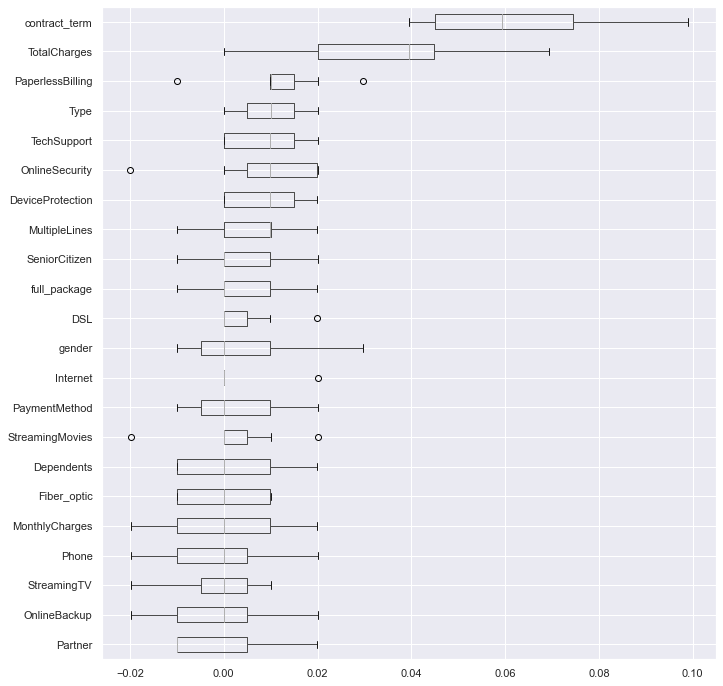

In [23]:
def get_lofo_importance(df, target):
    cv = KFold(n_splits=7, shuffle=False, random_state=RND) # схема проверки

    dataset = Dataset(
        df=df.sample(frac=0.1, random_state=RND), 
        target=target, 
        features=df.drop([target], axis=1).columns
    )

        #определяем схему проверки и оценщика. Модель по умолчанию LightGBM
    lofo_imp = LOFOImportance(dataset, cv=cv, scoring="accuracy")
        # получаем среднее и стандартное отклонение значений в формате pandas
    return lofo_imp.get_importance()

# строим график значений средних и стандартных отклонений
plot_importance(get_lofo_importance(df_telecom, 'isOut'), figsize=(11, 12), kind="box")

Из графика понятно, что наиболее важными признаками являются `contract_term` и `TotalCharges`

### 3.1.2 Корреляция числовых признаков<a id="3.1.2"></a>

Корреляция это взаимосвязь двух или нескольких случайных параметров. Когда одна величина растет или уменьшается, другая тоже изменяется.

<AxesSubplot:>

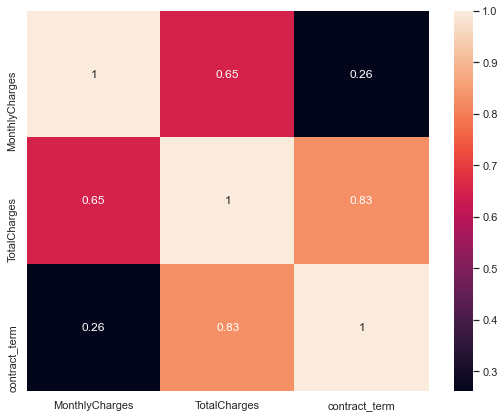

In [24]:
plt.figure(figsize = (9,7))
sns.heatmap(df_telecom[numeric].corr(),annot=True)

Данные имеют корреляцию 0.83 по признакам `TotalCharges` и `contract_term`. Рассмотрим подробнее.

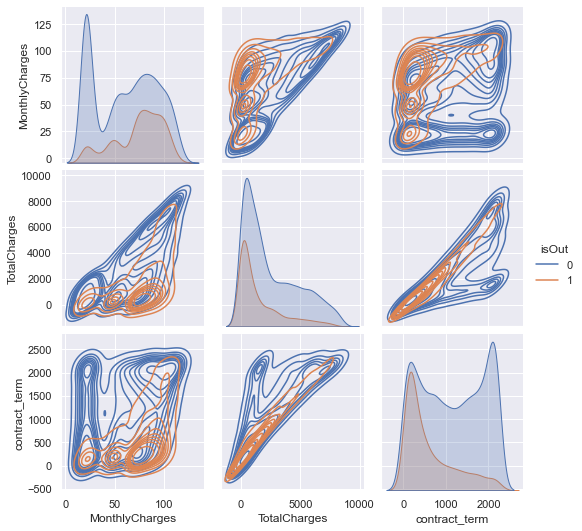

<Figure size 1080x1080 with 0 Axes>

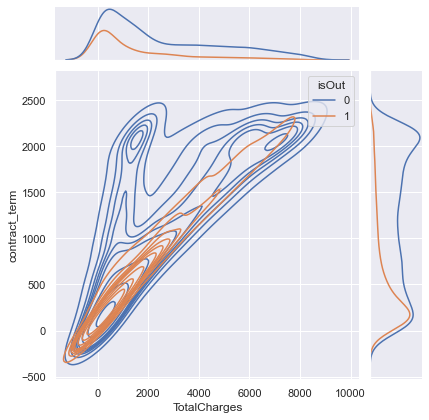

In [25]:
sns.pairplot(df_telecom[numeric+['isOut']],  kind="kde", hue='isOut', markers=['остались', 'ушли'])
plt.show()
plt.figure(figsize = (15,15))
sns.jointplot(
    x='TotalCharges',
    y='contract_term',
    data=df_telecom,
    kind='kde', #'scatter' or 'kde' or 'hex'
    hue="isOut"
)
plt.show()

Несмотря на корреляцию, распределение плотности вероятноти у ушедших клиентов и оставшихся имеет различный характер. На графике видно, что ушедшие клиетны имеют большую связь к времени контракта. Но оставшиеся имеют иное распределение. Проведем дополнительное исследование на мультиколинеарность.

### 3.1.3 Variance Inflation Factor (VIF тест)<a id="3.1.3"></a>
Коэффициент инфляции дисперсии (VIF) - это мера колинейности между предикторными переменными в рамках множественной регрессии.

**Последствия мультиколинеарности:**
- Возможная незначимость оценок параметров модели.
- Большие значения стандартных ошибок оценок параметров модели.
- Невозможность оценить влияние регрессоров по отдельности. 

**Что можно сделать с колинеарностью**

- Ничего, поскольку оценки параметров являются несмещенными и эффективными. Иногда даже прогноз по такой модели получается приемлемым.

- Добавить дополнительные наблюдения. К сожалению, не всегда возможно.

- Просто исключить из модели ту переменную, которая наиболее тесно связана с наибольшим количеством других факторов. Это приведет к некоторой потери информации, но зато оценки параметров при оставшихся переменных будут статистически значимы.

- Переопределить переменные, например, перейти к первым разностям, либо к логарифмам, и т.п.  
- Использовать априорные предположения о взаимосвязи между регрессорами, т.е. фактически наложить ограничения на параметры. Тогда способ действия: линейные ограничения на параметры модели.

- Перейти в пространство факторов меньшей размерности. Одним из способов снижения размерности является метод главных компонент (МГК). В этом методе из исходных факторов определенным образом строятся линейные комбинации – главные компоненты, которые ортогональны. Затем построенные ГК можно использовать для построения регрессионной модели. Недостаток: ГК не всегда интерпретируемы.

In [26]:
def sklearn_vif(exogs, data):
    vif_dict, tolerance_dict = {}, {}

    # входные данные для каждой экзогенной переменной
    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        X, y = data[not_exog], data[exog]

        # извлекаем r-квадрат
        r_squared = LinearRegression().fit(X, y).score(X, y)

        # считаем VIF
        vif = 1/(1 - r_squared)
        vif_dict[exog] = vif

        # допуск
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif

In [27]:
df = df_telecom
exogs = numeric

display(sklearn_vif(exogs=exogs, data=df))

,VIF,Tolerance
MonthlyCharges,3.066412,0.326114
TotalCharges,9.157515,0.109200
contract_term,5.659602,0.176691


### Интерпретация VIF

VIF, 	Статус предсказателей

- VIF = 1	 Не коррелирует
- 1 < VIF < 5	Умеренно коррелирует
- VIF > 5 до 10	Высоко коррелированные
- VIF > 10 объясняющие переменные, коррелирующие между собой, считаются мультиколлинеарными.

Значение показателя `Tolerance` должно превышать 0.1, а значение показателя `VIF` должно быть менее 10.0 В нашем случае значение `Tolerance` для `TotalCharges`, `contract_term` составляет 0.1, 0.17 а `VIF` — 9.15, 5.65, что свидетельствует о  высоко коррелированных признаках.

В качестве мер по предупреждению негативных последствий высокой корреляции наложим линейные ограничения на параметры модели в виде регуляризации методами **lasso** и **Ridge**.

## 3.2 Сравнение  распределения величин ежемесячных платежей (MonthlyCharges) всех клиентов и тех, кто ушёл<a id="3.2"></a>

In [28]:
all_contract = df_telecom['MonthlyCharges']
exited_contract = df_telecom.loc[df_telecom['isOut'] == 1]['MonthlyCharges']

In [29]:
print('статистика месячных платежей для всех клиентов' )
display(all_contract.describe().T)
print('статистика месячных платежей для ушедших клиентов')
display(exited_contract.describe().T)

статистика месячных платежей для всех клиентов


count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

статистика месячных платежей для ушедших клиентов


count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: MonthlyCharges, dtype: float64

Ушедшие клиенты платили больше

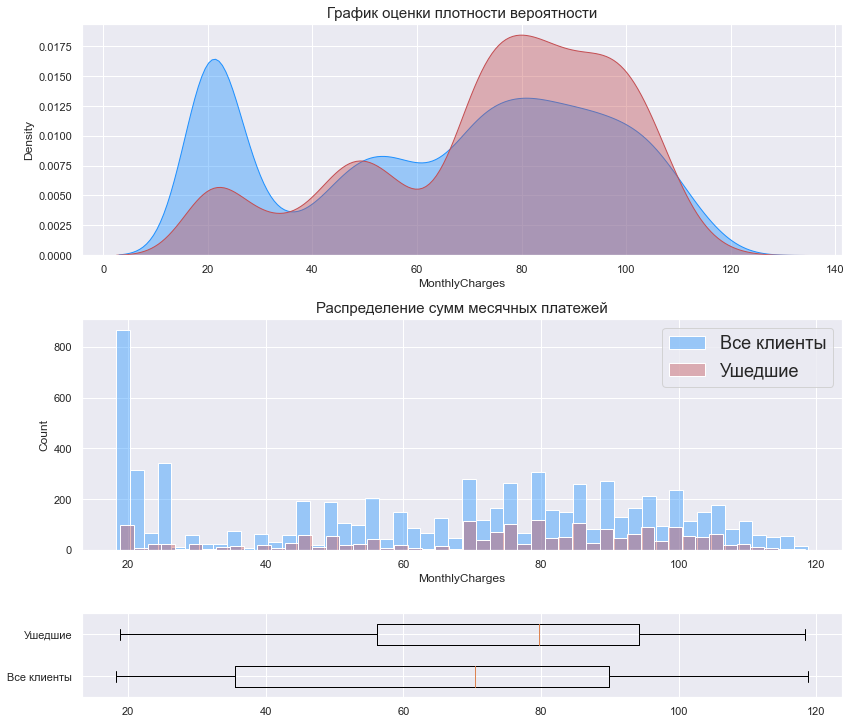

In [30]:
gridsize = (6, 1)
fig = plt.figure(figsize=(12, 12))    
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=2) 
ax2 = plt.subplot2grid(gridsize, (2, 0), colspan=1, rowspan=2)
ax3 = plt.subplot2grid(gridsize, (4, 0))
ax1.set_title('График оценки плотности вероятности' ,fontsize=15)
sns.kdeplot(all_contract, shade=True, color="dodgerblue", label="Все клиенты", alpha=.4, ax = ax1)
sns.kdeplot(exited_contract, shade=True, color="r", label="Ушедшие", alpha=.4, ax = ax1)
ax2.set_title('Распределение сумм месячных платежей' ,fontsize=15) 
sns.histplot(all_contract, bins=50, alpha=0.4, color="dodgerblue", label = 'Все клиенты', ax = ax2)
sns.histplot(exited_contract, bins=50, alpha=0.4, color="r", label = 'Ушедшие', ax = ax2)
ax3.boxplot([all_contract, exited_contract], labels = ['Все клиенты', 'Ушедшие'], vert=False, widths = 0.5)
ax2.legend(loc = 'upper right', fontsize = 18)
fig.tight_layout()

Большинство ушедших клиентов ежемесячно платили от 70 до 100, что значительно больше среднего от всех клиентов.

### Гипотеза о равенстве средних месячных оплат

Проверим гипотезу что средняя помесячная оплата ушедших клиентов не отличается от всех. 

- Гипотеза (H0) Средняя помесячная оплата ушедших равна общей. 
- Гипотеза (H1) Средняя оплата отличается.

In [31]:
alpha = .01 #объём выборок больше 100. Критический уровень статистической значимости 1% даст более точные результаты.

results = st.ttest_ind(
    all_contract, 
    exited_contract, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.672642398172353e-45
Отвергаем нулевую гипотезу


По результатам статистического теста отвергаем нулевую гипотезу **Средняя оплата отличается**

## 3.3 Изучиение влияния различных факторов на месячную оплату графически <a id="3.3"></a>

График плотности показывает бимодальность, значит, что в выборке имеются подвыборки. Посмотрим влияния различных факторов

In [32]:
factors = ['Type', 'PaperlessBilling', 'PaymentMethod',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'isOut',
       'full_package', 'Internet', 'Fiber_optic', 'DSL',
       'Phone']

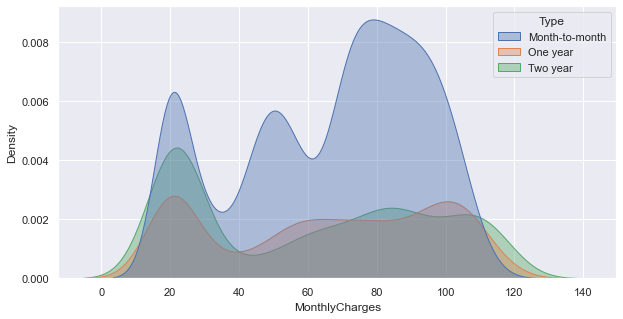

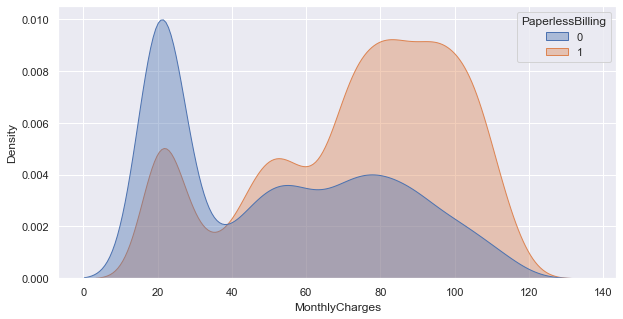

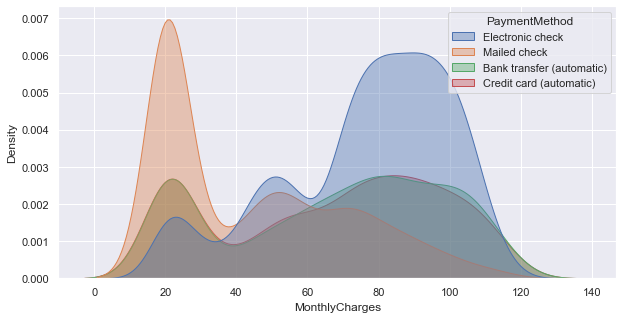

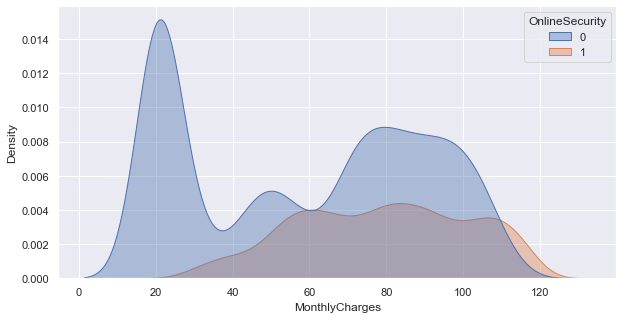

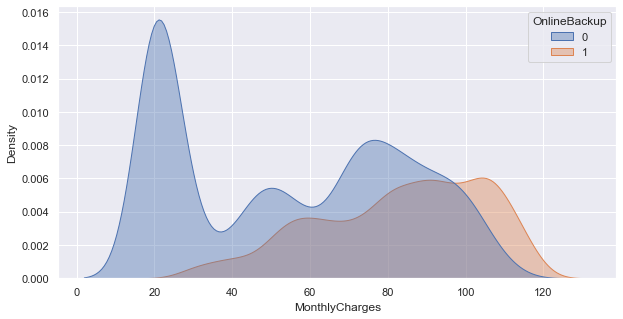

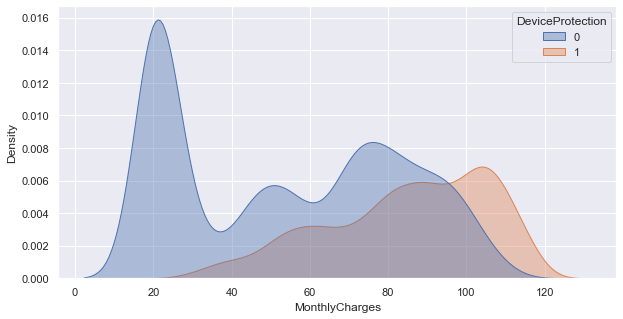

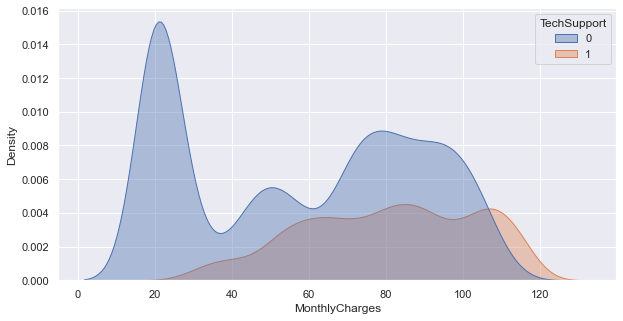

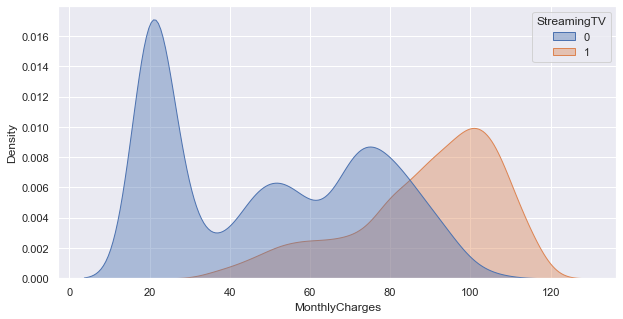

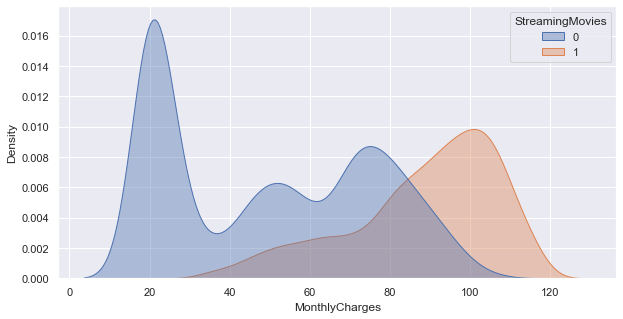

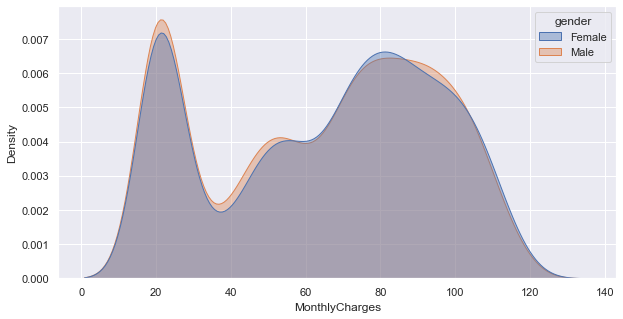

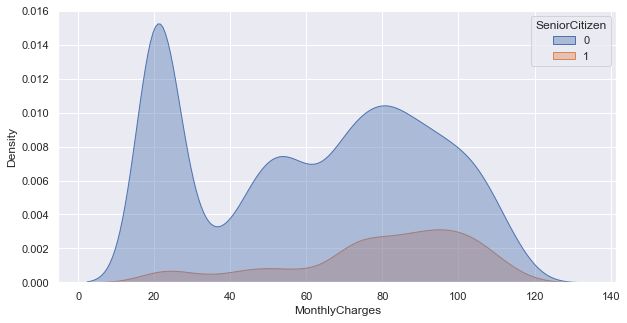

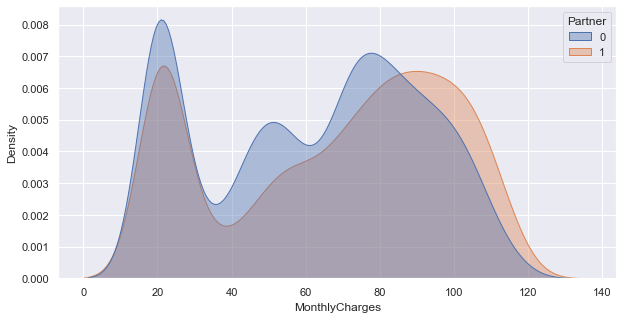

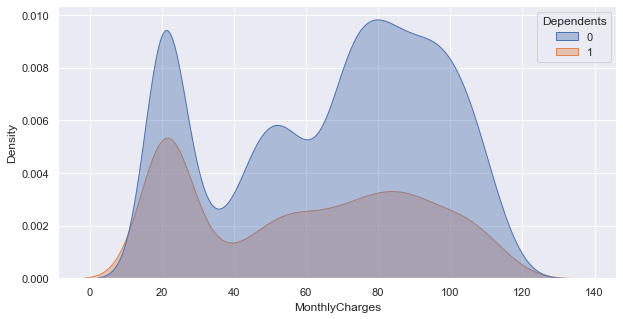

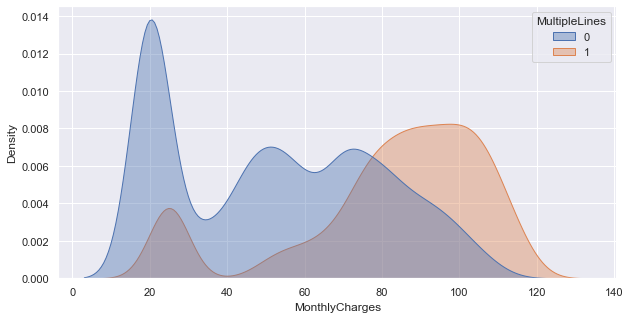

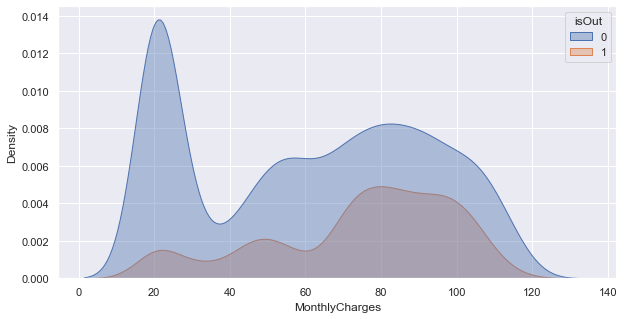

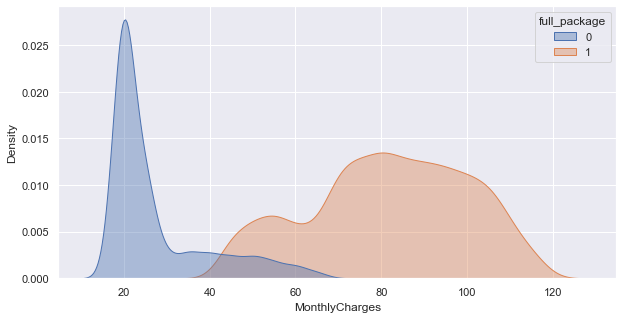

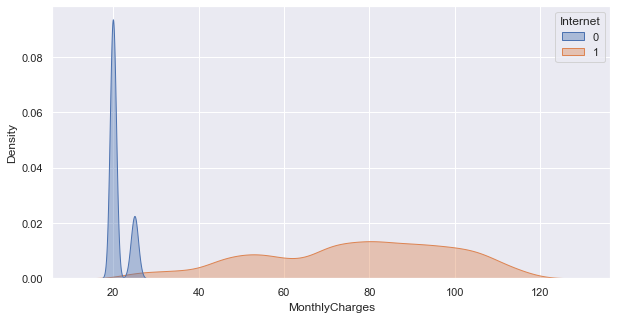

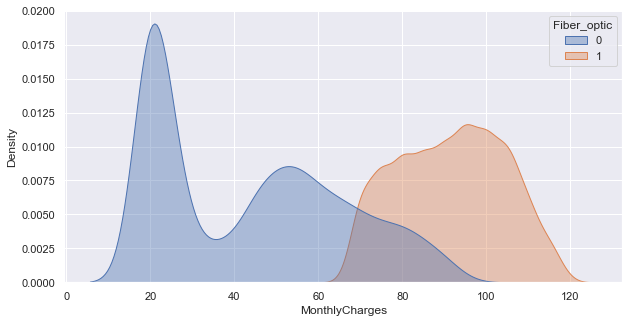

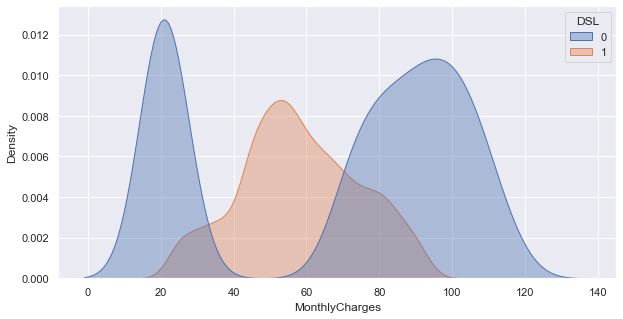

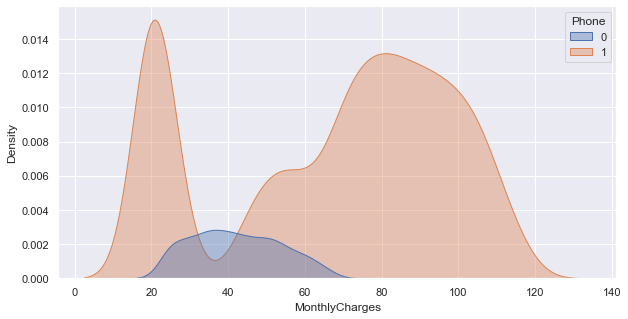

In [33]:
for col in factors:
    plt.figure(figsize = (10,5))
    sns.kdeplot(x = df_telecom['MonthlyCharges'], hue = df_telecom[col], 
                    shade=True, color="dodgerblue", label="col", alpha=.4)

Наибольшее влияние на такое бимодальное распределение оказывают типы подключений к интернету, наличие в тарифе нескольких услуг, наличие телефона.

## 3.4 Численные данные<a id="3.4"></a>

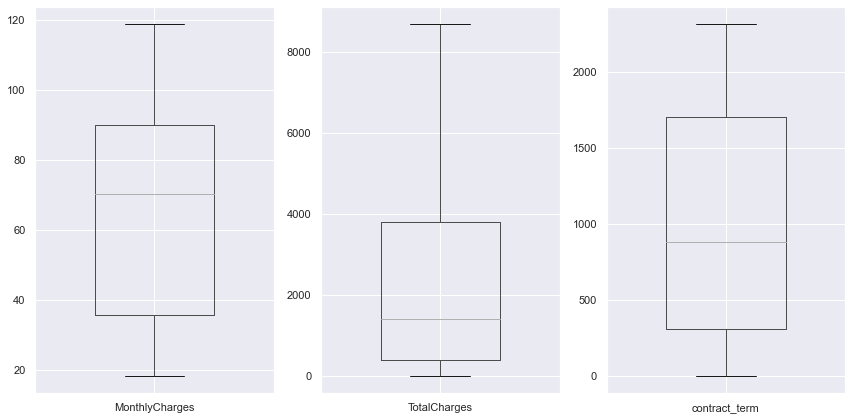

In [34]:
def print_box(dataset, column_name, axn):
    data_select = dataset.loc[:,[column_name]]
    data_select.boxplot(widths = 0.5 , ax=axn)

def box_plot(dataset, columns):
    fig, axis = plt.subplots(1, len(columns), figsize=(12, 6))
    ax = axis.ravel()
    for i in range(len(columns)):
        print_box(dataset, columns[i], ax[i])
    fig.tight_layout()


box_plot(df_telecom, numeric)

TotalCharges имеет выраженный скос вправо наборе данных, что означает, что оператору связи есть куда расти, и следует привлекать клиентов более дорогих услуг. Ну или не терять )

## 3.5 Изучение целевого признака<a id="3.5"></a>
Просмотрим доли клиентов с телефоном и интернетом

Общее число абонентов: 7043 (100.0%)
Число абонентов с Итернетом: 5517 (78.3%)
Число абонентов с телефоном: 6361 (90.3%)
Число абонентов с услугой Интернет + телефон: 4835 (68.6%)
Число абонентов телефоном и без интернета: 682 (9.7%)
Число абонентов с Интернетом и без телефона: 1526 (21.7%)


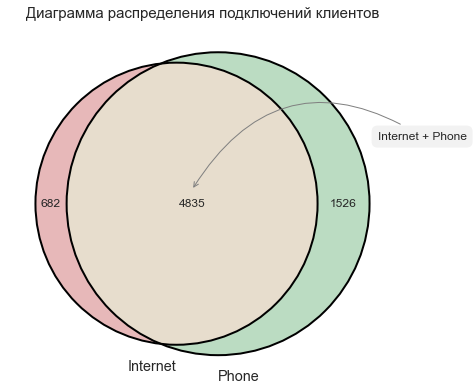

In [35]:
total = df_telecom.shape[0]
k_int = df_telecom.loc[df_telecom['Internet']==1].shape[0]
k_tel = df_telecom.loc[df_telecom['Phone']==1].shape[0]
k_int_tel = df_telecom.loc[df_telecom['full_package'] == 1].shape[0]

print('Общее число абонентов: {} ({:.1%})'.format(total, total/total))
print('Число абонентов с Итернетом: {} ({:.1%})'.format(k_int, k_int/total))
print('Число абонентов с телефоном: {} ({:.1%})'.format(k_tel, k_tel/total))
print('Число абонентов с услугой Интернет + телефон: {} ({:.1%})'.format(k_int_tel, k_int_tel/total))
print('Число абонентов телефоном и без интернета: {} ({:.1%})'.format(k_int-k_int_tel, (k_int-k_int_tel)/total))
print('Число абонентов с Интернетом и без телефона: {} ({:.1%})'.format(k_tel-k_int_tel, (k_tel-k_int_tel)/total))

plt.figure(figsize=(7,7))
v = venn2(subsets={'10': k_int-k_int_tel, '01': k_tel-k_int_tel, '11': k_int_tel}, set_labels = ('Internet', 'Phone'))
venn2_circles((k_int-k_int_tel, k_tel-k_int_tel, k_int_tel))
plt.title("Диаграмма распределения подключений клиентов",fontsize=15)
plt.annotate('Internet + Phone', xy=v.get_label_by_id('11').get_position() - np.array([0, -0.05]), xytext=(230,50),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))

plt.show()

Большая часть имеет подключение internet + телефон

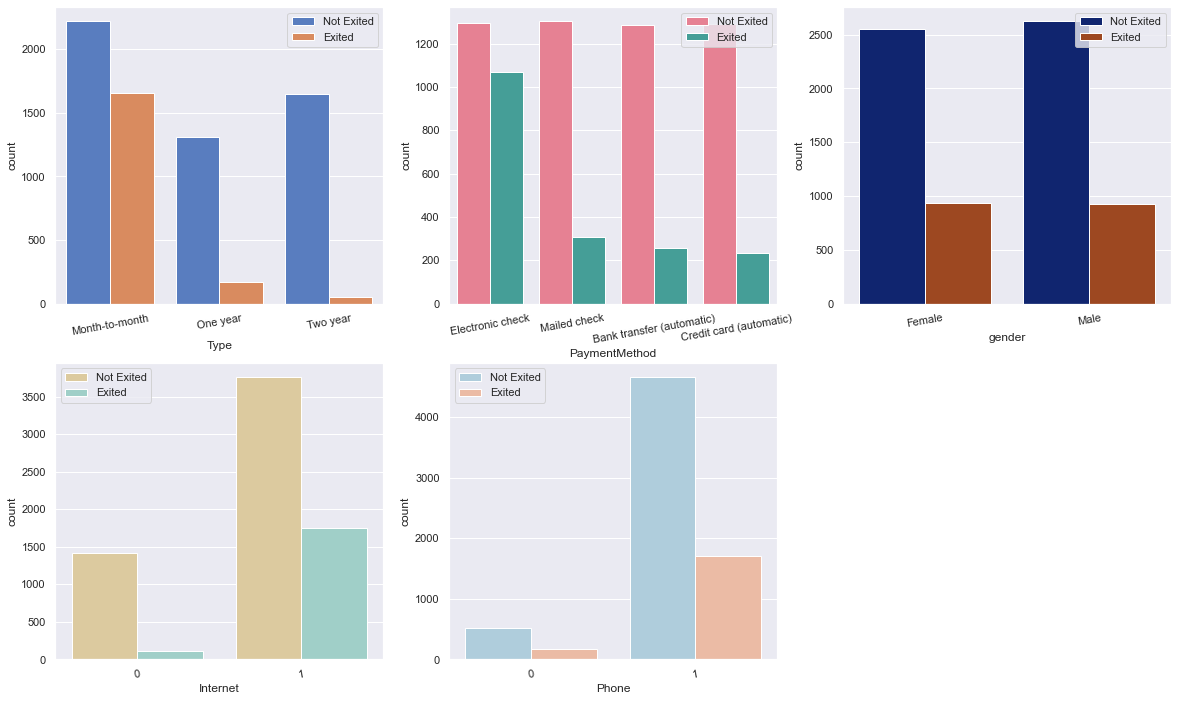

In [36]:
plt.figure(figsize=(20,12))

color=["muted","husl","dark","BrBG" ,"RdBu_r", "muted"]

for i in range(len(categorical+['Internet', 'Phone'])):
    plt.subplot(2,3,i+1)
    sns.countplot(x=(categorical+['Internet', 'Phone'])[i], hue='isOut', data=df_telecom, palette=color[i])
    plt.xticks(rotation=10)
    plt.legend(["Not Exited", "Exited"])
plt.show()

Наиболее вероятные признаки ухода:

- ежемесячный платеж
- электронный платеж


### Баланс классов целевого признака

<AxesSubplot:xlabel='isOut', ylabel='count'>

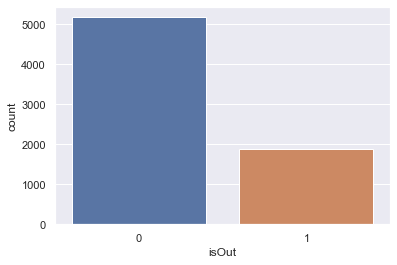

In [37]:
sns.countplot(df_telecom['isOut'])

Налицо дисбаланс классов. В моделях будем использовать  `class_weight='balanced'`

# 4 Подготовка выборок для моделей<a id="4"></a>
## 4.1 Кодирование категориальных признаков<a id="4.1"></a>

In [38]:
df_telecom = pd.get_dummies(df_telecom, columns=categorical, drop_first=True)

## 4.2 Масштабирование признаков<a id="4.2"></a>

In [39]:
df_telecom[numeric] = preprocessing.normalize(df_telecom[numeric])

## 4.3 Получение тренировочной, валидационной и тестовых выборок<a id="4.3"></a>

In [40]:
# Разделим признаки на тренировочный и целевой
features = df_telecom .drop(['isOut'], axis=1)
target = df_telecom ['isOut']

In [41]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=RND)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=RND)

In [42]:
print('    Размеры выборок')
print('features_train size:', features_train.shape[0])
print('features_valid size:', features_valid.shape[0])
print('features_test size:', features_test.shape[0])

    Размеры выборок
features_train size: 4225
features_valid size: 1409
features_test size: 1409


# 5 Подбор моделей<a id="5"></a>
Результаты обучений будем записывать в список `fit_result` и словарь для моделей `models`

In [43]:
fit_result = []
models = {}

scorer = make_scorer(roc_auc_score)

def AUC_predict_score(model, X_valid, y_valid):
    try:
        predictions = model.predict_proba(X_valid)
        mROC_AUC = roc_auc_score(y_valid, predictions[:, 1])
    except:
        predictions = model.predict(X_valid)
        mROC_AUC = roc_auc_score(y_valid, predictions)
    print('ROC_AUC:', mROC_AUC)
    return mROC_AUC
    

def searchCV(estimator, param_grid, X, y):
    gs = GridSearchCV(estimator=estimator,
                          param_grid=param_grid,
                          cv= 3,
                          verbose = 0, 
                          scoring = scorer,
                          n_jobs=-1)
    gs.fit(X, y)
    #display('best_params: ', gs.best_params_)
    return gs.best_estimator_

## 5.1 Пробная оценка моделей кросс валидациией<a id="5.1"></a>

In [44]:
def model_test(features_train, features_valid, target_train, target_valid):
    kfold = 5 #количество подвыборок для валидации
    itog_val = {} #список для записи результатов кросс валидации разных алгоритмов
    
    model_dummy = DummyClassifier(random_state=RND)
    model_forest = RandomForestClassifier(random_state=RND, n_estimators = 30, class_weight='balanced')
    model_tree = DecisionTreeClassifier(random_state=RND, max_depth=15)
    model_lr = LogisticRegression(random_state=RND, solver='liblinear') 
    model_knc = KNeighborsClassifier(n_neighbors = 12) #в параметре передаем кол-во соседей

    #print(cross_val_score(lasso, X, y, cv=3))
    # cross_val_score сама разделяет обучающую и валид. выборку
    scores = cross_val_score(model_dummy, features, target, cv = kfold) 
    itog_val['DummyClassifier'] = scores.mean()
    scores = cross_val_score(model_forest, features, target, cv = kfold) 
    itog_val['RandomForestClassifier'] = scores.mean()
    scores = cross_val_score(model_knc, features, target, cv = kfold)
    itog_val['KNeighborsClassifier'] = scores.mean()
    scores = cross_val_score(model_tree, features, target, cv = kfold)
    itog_val['DecisionTreeClassifier'] = scores.mean()
    scores = cross_val_score(model_lr, features, target, cv = kfold)
    itog_val['LogisticRegression'] = scores.mean()

    plt.figure(figsize=(8,6))

        #RandomForestClassifier
    probabilities = model_forest.fit(features_train, target_train).predict_proba(features_valid)
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities[:, 1])
    roc_auc  = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{} ROC (area = {:.2f})'.format('RandomForestClassifier',roc_auc))
        #DecisionTreeClassifier
    probabilities = model_tree.fit(features_train, target_train).predict_proba(features_valid)
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities[:, 1])
    roc_auc  = auc(fpr, tpr) # просто, чтобы не одинаково :)
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('DecisionTreeClassifier',roc_auc))
        # KNeighborsClassifier
    probabilities = model_knc.fit(features_train, target_train).predict_proba(features_valid)
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities[:, 1])
    roc_auc  = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('KNeighborsClassifier',roc_auc))
        #LogisticRegression
    probabilities = model_lr.fit(features_train, target_train).predict_proba(features_valid)
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities[:, 1])
    roc_auc  = auc(fpr, tpr) 
    plt.plot(fpr, tpr, label='LogisticRegression ROC (area = {:.2f})'.format(roc_auc))
        # DummyClassifier
    probabilities = model_dummy.fit(features_train, target_train).predict_proba(features_valid)
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities[:, 1])
    roc_auc  = auc(fpr, tpr) 
    plt.plot(fpr, tpr, label='DummyClassifier ROC(area = {:.2f})'.format(roc_auc))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.grid(True)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=0, fontsize='12')
    plt.show()

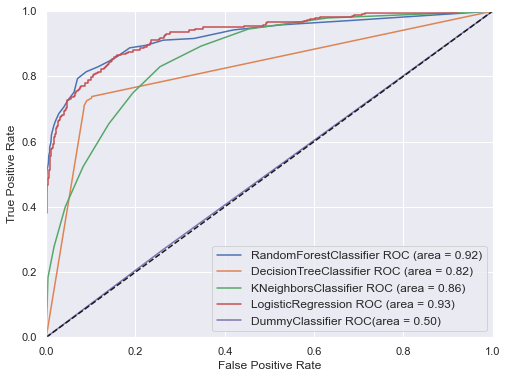

In [45]:
model_test(features_train, features_valid, target_train, target_valid)

Различные манипуляции над датасетами лучший результат не дают. Далее будем использовать первичный набор данных. Также попробуем улучшить пару, хорошо показавших себя, моделей: Логистическая регрессия и случайный лес - классификатор.

## 5.2 Модель по умолчанию<a id="5.2"></a>
чтобы было с чем сравнить

In [46]:
model_dummy = DummyClassifier(random_state=RND)
model_dummy.fit(features_train, target_train)
score = AUC_predict_score(model_dummy, features_valid, target_valid)

# сохраняем результат
fit_result.append(['Dummy', 'valid', round(score, 2)])
models['Dummy'] = model_dummy

ROC_AUC: 0.503517590501486


## 5.3 RandomForestClassifier<a id="5.3"></a>


### 5.3.1 Оптимизация гиперпараметров дл RFC с RandomizedSearchCV<a id="5.3.1"></a>

In [47]:
model_RFС = RandomForestClassifier(random_state=RND, class_weight='balanced', ccp_alpha=0.01)

In [48]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 16)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 2, stop = 30, num = 10)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 30, num = 5)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 10, num = 3)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(model_RFС, 
                        param_dist, 
                        n_iter = 50, # количество заходов
                        cv = 3, 
                        verbose = 1,
                        n_jobs=-1, 
                        random_state=RND)
rs.fit(features_train, target_train)
display(rs.best_params_)
#print('accuracy',rs.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   52.7s finished


{'n_estimators': 402,
 'min_samples_split': 2,
 'min_samples_leaf': 10,
 'max_features': 'sqrt',
 'max_depth': 17,
 'bootstrap': True}

При значениях параметров `n_iter =`  и `cv =` , мы создем  `(n_iter * cv)` RF-моделей, случайно выбирая комбинации гиперпараметров. лучшие атрибуты можно получть, если обратиться к атрибуту `best_params_`.

Получаем датафрейм от `rs.cv_results_`, для того чтобы визуализировать и выяснить, в каком диапазоне значений стоит продолжать поиск.

In [49]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
#rs_df.head(5)

Чтобы понять в какую сторону идти в поисках параметроз, создадим графики.

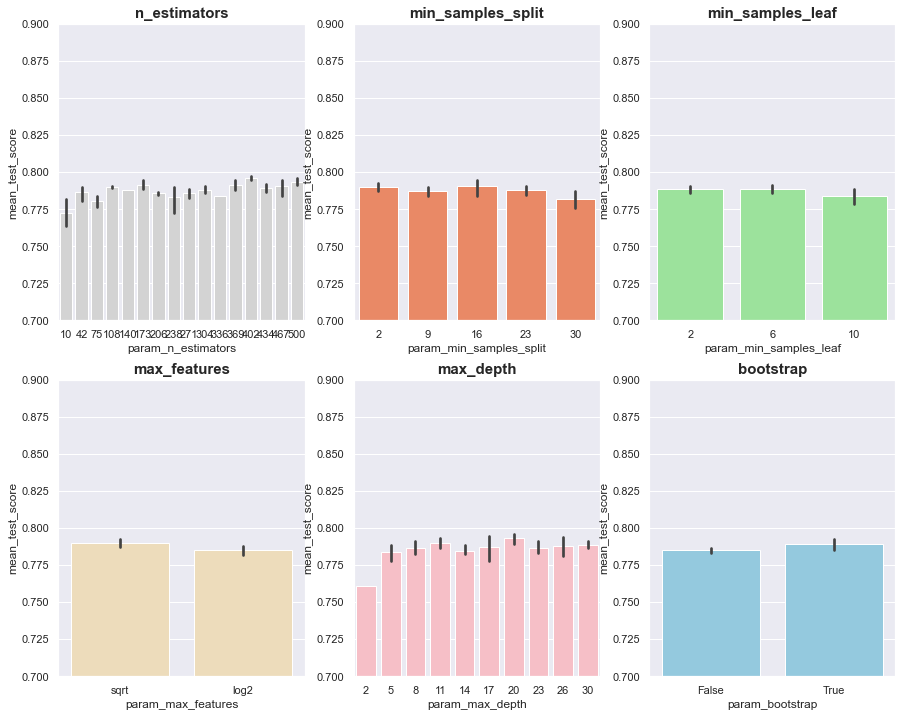

In [50]:
fig, axs = plt.subplots(ncols=3, nrows=2)
#sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(15,12)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([0.7,0.9]), 
axs[0,0].set_title(label = 'n_estimators', size=15, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([0.7,0.9]), 
axs[0,1].set_title(label = 'min_samples_split', size=15, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([0.7,0.9]), 
axs[0,2].set_title(label = 'min_samples_leaf', size=15, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([0.7,0.9]), 
axs[1,0].set_title(label = 'max_features', size=15, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([0.7,0.9]), 
axs[1,1].set_title(label = 'max_depth', size=15, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([0.7,0.9])
axs[1,2].set_title(label = 'bootstrap', size=15, weight='bold')
plt.show()

### 5.3.2 Анализ значений гиперпараметров<a id="5.3.2"></a>

Графики показывают, как, в среднем, каждое значение гиперпараметра влияет на модель.

* **n_estimators:** значения около 475 Можно исследовать несколько значений около этого гиперпараметра.
* **min_samples_split:** Хорошо выглядит и значения 16 и 2 показывают наилучшие средние результаты.
* **min_samples_leaf:** 2 и 3 выглядят перспективно.
* **max_features:** вариант sqrt даёт самый высокий средний результат.
* **max_depth:** при глубине около 20 наилучший результат.
* **bootstrap:** значение False показывает наилучший средний результат.

### 5.3.3 Оптимизация гиперпараметров. Окончательная подготовка параметров с GridSearchCV Hyperparameter Tuning для модели RFC <a id="5.3.3"></a>
После `RandomizedSearchCV`, мы сузили диапазоны значений исследуемых параметров, и далее используем алгоритм `GridSearchCV` для проведения более точного поиска наилучшей комбинации гиперпараметров. 

In [51]:
n_estimators = [206,402]
min_samples_split = [2,16]
min_samples_leaf = [2,5]
max_features = ['sqrt']
max_depth = [11, 20]
bootstrap = [True]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rfc_model = searchCV(model_RFС, param_grid, features_train, target_train)
score = AUC_predict_score(rfc_model, features_valid, target_valid)

# сохраняем результат
fit_result.append(['RFC', 'valid', round(score, 2)])
models['RFC'] = rfc_model

ROC_AUC: 0.8970773411094175


## 5.4 LogisticRegression <a id="5.4"></a>

In [52]:
lr_model = LogisticRegression(random_state=12345, 
                              class_weight='balanced', 
                              solver = 'saga', 
                              penalty='elasticnet', 
                              l1_ratio=0.01
                             ) 
param_grid = {
    'C': [1, 2.5, 3], 
    'max_iter':np.linspace(100, 200, 2)
}

lr_model = searchCV(lr_model, param_grid, features_train, target_train)
score = AUC_predict_score(lr_model, features_valid, target_valid)

fit_result.append(['LR', 'valid', round(score, 2)])
models['LR'] = lr_model

ROC_AUC: 0.9417048588630536


## 5.5 Градиентный бустинг<a id="5.5"></a>

In [53]:
param_grid = {'max_depth' : [3, 5, 8, 15]}

xgb_model = searchCV(xgb.XGBRegressor(reg_alpha = 0.01), param_grid, features_train, target_train)
score = AUC_predict_score(xgb_model, features_valid, target_valid)

fit_result.append(['XGBoost', 'valid', round(score, 2)])
models['XGBoost'] = xgb_model

ROC_AUC: 0.9471851629052238


## 5.6 Нейронная сеть fully connected<a id="5.6"></a>

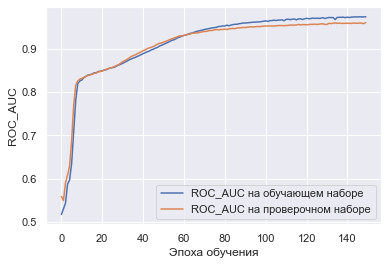

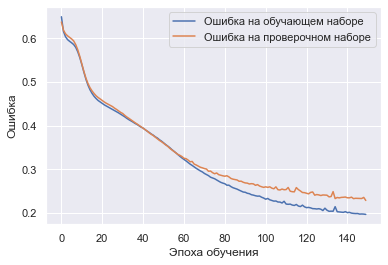

ROC_AUC: 0.9606463190199687


In [79]:
nn_model = Sequential()

nn_model.add(Dense(units=15, input_dim=features_train.shape[1], 
                   activation='sigmoid',
                   activity_regularizer=keras.regularizers.l1(0.01)
                  )
            )
nn_model.add(Dense(units=10, activation='sigmoid',
                   activity_regularizer=keras.regularizers.l2(0.01)
                  )
            )
nn_model.add(Dense(units=3, activation='sigmoid'))
nn_model.add(Dense(units=1, activation='sigmoid'))

nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[AUC(name='auc')])
history = nn_model.fit(features_train, target_train, epochs=150, verbose=0,                          
          validation_data=(features_valid, target_valid))

## Визуализация обучения сети
plt.plot(history.history['auc'], label='ROC_AUC на обучающем наборе')
plt.plot(history.history['val_auc'], label='ROC_AUC на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('ROC_AUC')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

score = AUC_predict_score(nn_model, features_valid, target_valid)

fit_result.append(['NN', 'valid', round(score, 2)])
models['NN'] = nn_model

На валидационной выборке модели показывают неплохой результат. Посмотрим на тестовой выборке.

# 6 Тестирование<a id="6"></a>
## 6.1 Проверка на тестовой выборке<a id="6.1"></a>

In [80]:
for k,v in models.items():
    print('-'*30)
    print(k)
    score = AUC_predict_score(v, features_test, target_test)
    fit_result.append([k, 'test', round(score, 2)])

------------------------------
Dummy
ROC_AUC: 0.505194009288945
------------------------------
RFC
ROC_AUC: 0.8768100527251455
------------------------------
LR
ROC_AUC: 0.9311838086700197
------------------------------
XGBoost
ROC_AUC: 0.93486722481374
------------------------------
NN
ROC_AUC: 0.944742426774852


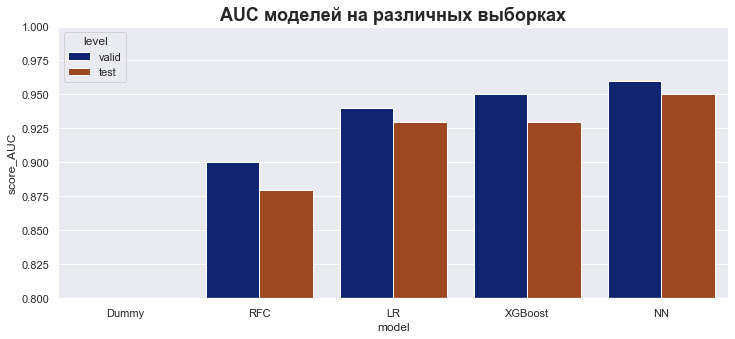

In [81]:
fit_result = pd.DataFrame(fit_result, columns = ['model', 'level', 'score_AUC'])

plt.figure(figsize=(12,5))
ax = sns.barplot(x='model', y="score_AUC", hue="level", data=fit_result, palette="dark")
ax.set(ylim=(0.8,1))
ax.set_title(label = 'AUC моделей на различных выборках', size=18, weight='bold')
plt.show()

Лучшей себя показала полносвязная нейронная сеть из четырех слоев. Попробуем обучить её на данных объединенных из тренировочной и валидационной выборок.

## 6.2 Увеличение выборки<a id="6.2"></a>

In [82]:
if 'final_features' not in locals():
    final_features = pd.concat([features_train]+[features_valid])
    final_target = pd.concat([target_train]+[target_valid])

## 6.3 Дообучение лучшей модели на большей выборке. Сравнение с моделью по умолчанию<a id="6.3"></a>

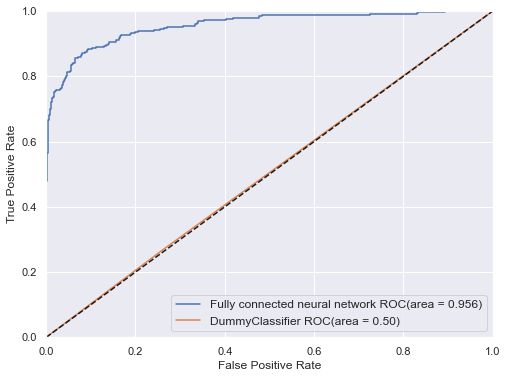

In [83]:
best_models = models['NN']

plt.figure(figsize=(8,6))
# NN
best_models.fit(final_features, final_target, epochs=150, verbose=0)
probabilities = best_models.predict_proba(features_test)
fpr, tpr, thresholds = roc_curve(target_test, probabilities)
roc_auc  = auc(fpr, tpr) 
plt.plot(fpr, tpr, label='Fully connected neural network ROC(area = {:.3f})'.format(roc_auc))
# dummy
probabilities = model_dummy.fit(features_train, target_train).predict_proba(features_valid)
fpr, tpr, thresholds = roc_curve(target_valid, probabilities[:, 1])
roc_auc  = auc(fpr, tpr) 
plt.plot(fpr, tpr, label='DummyClassifier ROC(area = {:.2f})'.format(roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid(True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='12')
plt.show()

Результат модели немного изменился в лучшую сторону.

# 7 Итоги <a id="7"></a>

**Какие пункты плана были выполнены, а какие — нет (поясните почему)?**

План был выполнен в полном объеме. И немного более. Небыло учтено нескольких нюансов в разделе аналитика данных.

**Какие трудности возникли и как вы их преодолели?**

Трудности возникли всвязи высокой коррелированностью двух главных признаков. К счастью эта проблема касалась только одного класса целевого признака, в частности - ушедших клиентов, у оставшихся клиентов корреляция и распределение вероятностей носят иной характер. Также для предупреждения возможных негативных последствий от колинеарности во всех моделях была применена L1 и L2 регуляризация.

**Какие ключевые шаги в решении задачи выделили?**

- Обработка ошибок и сбор данных в удобный для анализа и обучения вид
- Самое, пожалуй, важное - создать дополнительные признаки на основе имеющихся данных.
- Анализ данных дает представление о причинах возникновения случаев в целевой переменной, а также характер, зависимости и важность признаков. На основе анализа принимается решение о применении моделей, их параметров и метрик. 
- Обучение различных моделей.
- Тестирование, получение результатов и сравнение с моделью по умолчанию

**Какая ваша итоговая модель и какое у неё качество?**

Лучшей по итогам обучения стала **полносвязная нейронная сеть**, разработанная самостоятельно. 

Модель стабильно дает результат **ROC- AUC  0.957 +-0,01**
